## 실시간 향수/디퓨저 부분 랭킹 크롤링 함수 

In [2]:
def perfume_realtime_crawl(): 
    from bs4 import BeautifulSoup
    import json
    import requests

    # stats---- 크롤링 부분
    URL = 'https://rts.ai.oliveyoung.co.kr/api/stats'
    parameters='?type=view&size=100&categoryid=10000010005&cuid=8b47cf9f-efd1-48e4-8f83-10ee8a07945b'
    params = {    
    "type":"view",
    "size":"100",
    "categoryid":"10000010005",
    "cuid":"8b47cf9f-efd1-48e4-8f83-10ee8a07945b"
    }
    head = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"}
    response = requests.get(URL, params = params)
    response.status_code

    import json
    json_result = json.loads(response.text)

    # payload 준비
    itemid = [] # A000000170878 등 
    itemrank = [] # 위에서는 rank 값 
    itemview = [] # 위에서는 count 값
    for item in json_result['items']:
        temp  = str(item['itemUrl'])[8:]
        itemid.append(temp)
        itemrank.append(str(item['rank']))
        itemview.append(str(item['count']))
    itemid_str = ','.join(itemid)
    itemrank_str = ','.join(itemrank)
    itemview_str = ','.join(itemview)
    payloads = {'goodsNoStr':itemid_str, "rankStr":itemrank_str, 'viewCntStr':itemview_str}

    # getCuration--- 크롤링 부분
    URL = 'https://www.oliveyoung.co.kr/store/curation/getCurationRankBestListAjax.do'

    head = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"}
    response = requests.post(URL, headers=head, data=payloads )
    response.status_code
    soup = BeautifulSoup(response.text, 'html.parser')

    # 정보 얻어와서 리스트에 넣기
    results = soup.select('div.prd_info')
    realtime_itemlist = [] # 실시간 향수/디퓨저 랭킹 상품명
    realtime_brandlist = [] # 실시간 향수/디퓨저 랭킹 브랜드명
    realtime_viewlist = [] # 실시간 향수/디퓨저 랭킹 보고 있는 사람 수 
    for result in results :
        realtime_itemlist.append(str(result.select_one('.prd_name .tx_name'))[19:-4]) # 상품명
        realtime_brandlist.append(str(result.select_one('.prd_name .tx_brand'))[23:-7])
        realtime_viewlist.append(str(result.select_one('.prd_name .viewNum'))[22:-7])

    return realtime_itemlist , realtime_brandlist , realtime_viewlist 


In [15]:

realtime_itemlist , realtime_brandlist , realtime_viewlist =perfume_realtime_crawl() 

# 정보 합치기 함수
def make_dict(realtime_itemlist , realtime_brandlist , realtime_viewlist):
    alist = []
    for i in range(len(realtime_itemlist)):
        real_info =  {
            '제품명' : realtime_itemlist[i],
            '브랜드명' : realtime_brandlist[i],
            'Viewer 수': realtime_viewlist[i] 
        }
        alist.append(real_info)
    return alist

# make_dict(realtime_itemlist , realtime_brandlist , realtime_viewlist)


In [9]:
#몇분동안 내가 원하는 제품의 watcher 수를 꺾은선 그래프를 나타내보자
from time import sleep
import math
time= 100
print("약",math.ceil(time*10/60),"분 걸립니다. ")

# 10초마다 크롤링하여 total_list에 모두 넣기!  
total_list = []
for i in range(time):
    realtime_itemlist , realtime_brandlist , realtime_viewlist =perfume_realtime_crawl() 
    total_list.append(make_dict(realtime_itemlist , realtime_brandlist , realtime_viewlist))
    sleep(10)

# 원하는 상품명 찾고, 해당 viewer 수 view_count에 넣기
want_item = '헉슬리 퍼퓸 디스커버리 세트 (1.5ml*6ea)'
check  = 0 # 순위밖으로 밀려날 경우
view_count = []
for total in total_list:
    for detail in total : 
        if detail['제품명']==want_item:
            view_count.append(detail['Viewer 수'])
            check+=1
    if check ==0 :
        view_count.append(0)



약 17 분 걸립니다. 


In [14]:
# view_count

In [11]:
import pandas as pd
import numpy as np
import openpyxl
df = pd.DataFrame({'Viewer 수': view_count})
# 엑셀로 따로 저장하기 (크롤링하는데 오래 걸려서)
df.to_excel('test.xlsx', index=False)



In [12]:
# 엑셀 불러오기
view_excel = pd.read_excel('test.xlsx')

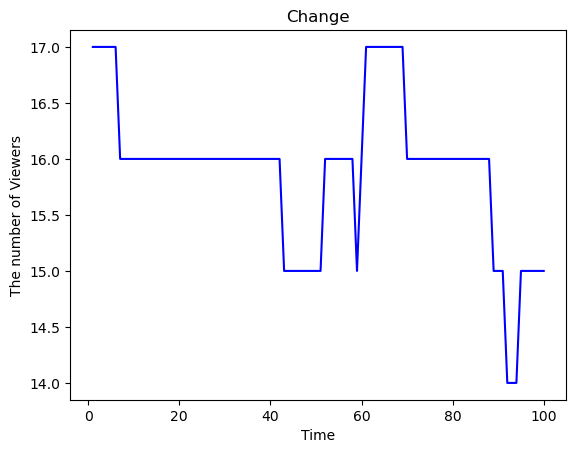

In [13]:
# 그래프 출력 
import matplotlib.pyplot as plt  
plt.plot([(i+1) for i in range(time)],view_excel['Viewer 수'],color='blue',linestyle='-')
plt.xlabel('Time') #x 라벨
plt.ylabel('The number of Viewers') #y 라벨
plt.title("Change") #그래프 이름
#그래프 출력
plt.show()